In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Analisis Exploratorio de los datos

#Apuntar
Después de preparar nuestros datos, todavía queremos darles sentido. En EDA analizamos varios argumentos y dejamos que los datos nos cuenten su historia. Este paso nos dará una comprensión más profunda de los datos. También intentaremos hacer que los datos sean más fáciles de modelar. Veremos varias tablas en la base de datos.

Usaremos matplolib y seaborn para crear varios gráficos.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
from sqlite3 import dbapi2 as sq3
from pathlib import Path
from collections import OrderedDict

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras


from time import time
from IPython.display import clear_output
from collections import OrderedDict

plt.style.use('ggplot')

In [7]:
# Funcion para trabajar con SQLite db
def make_query(sel):
    """Query database"""
    c = db.cursor().execute(sel)
    return c.fetchall()

def make_frame(list_of_tuples=None, legend=[], query=None):
    """
    Retorna DataFrame desde un query o resultado de un query
    """
    framelist=[]
    if list_of_tuples is None:
        if query is None:
            print("Error: No se realizó ninguna consulta")
            return
        list_of_tuples = make_query(query)

    for i, cname in enumerate(legend):
        framelist.append((cname,[e[i] for e in list_of_tuples]))
    return pd.DataFrame.from_dict(OrderedDict(framelist))

# Conectar a base de datos
db = sq3.connect('/content/drive/MyDrive/Colab Notebooks/yelp_database.db')

#Reviews Tabla

In [8]:
# Mirando las columnas de la tabla de 'reseñas'
make_query("PRAGMA table_info(reviews)")

[(0, 'review_id', 'VARCHAR', 0, None, 1),
 (1, 'user_id', 'INTEGER', 0, None, 0),
 (2, 'business_id', 'INTEGER', 0, None, 0),
 (3, 'stars', 'FLOAT', 0, None, 0),
 (4, 'useful', 'INTEGER', 0, None, 0),
 (5, 'funny', 'INTEGER', 0, None, 0),
 (6, 'cool', 'INTEGER', 0, None, 0),
 (7, 'text', 'VARCHAR', 0, None, 0),
 (8, 'date', 'TIMESTAMP', 0, None, 0)]

In [9]:
%%time
# Obteniendo pandas DataFrame desde db
date_df = make_frame(query="SELECT stars, date FROM reviews", legend=['rating', 'date'])
date_df.date = pd.to_datetime(date_df.date)
date_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378600 entries, 0 to 378599
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   rating  378600 non-null  float64       
 1   date    378600 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.8 MB
CPU times: user 726 ms, sys: 335 ms, total: 1.06 s
Wall time: 2.53 s


In [10]:
#Creando nuevas columnas en reseñas df
date_df['day'] = date_df.date.dt.day
date_df['month'] = date_df.date.dt.month
date_df['year'] = date_df.date.dt.year
date_df['hour'] = date_df.date.dt.hour
date_df['minute'] = date_df.date.dt.minute
date_df['second'] = date_df.date.dt.second

date_df.head()

,rating,date,day,month,year,hour,minute,second
0,4.0,2015-04-15 15:30:48,15,4,2015,15,30,48
1,1.0,2018-02-11 03:11:20,11,2,2018,3,11,20
2,1.0,2013-12-07 13:17:13,7,12,2013,13,17,13
3,5.0,2017-10-11 01:27:15,11,10,2017,1,27,15
4,5.0,2018-03-04 00:20:24,4,3,2018,0,20,24


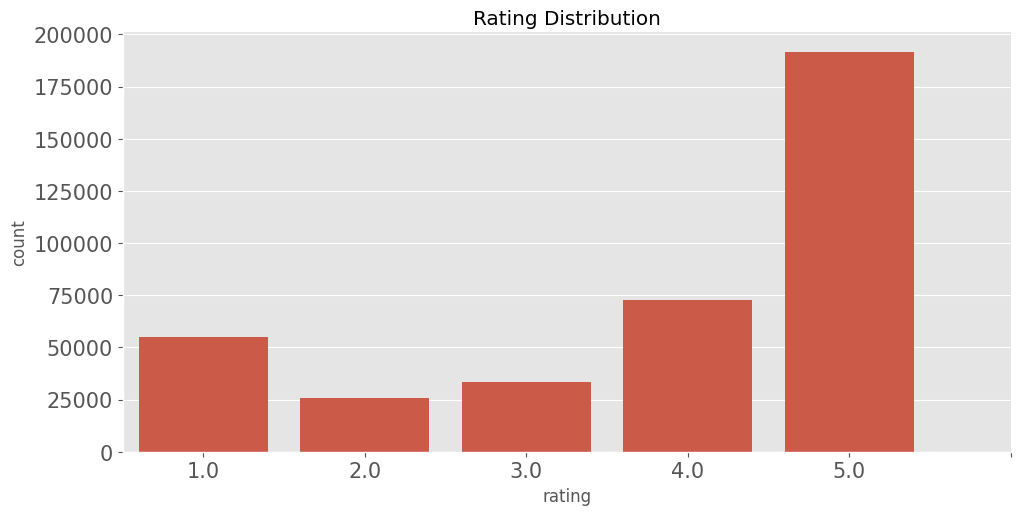

In [11]:
sns.catplot(data=date_df, x='rating', kind='count', aspect=2)
ax = plt.gca()
ax.set(xticks=[0,1,2,3,4,5], title='Rating Distribution')
ax.tick_params('x', labelsize=15)
ax.tick_params('y', labelsize=15)

Vemos que la mayoría de las calificaciones están en la escala más alta. La mayoría de las calificaciones son de 5 o 4 estrellas.

Text(0.5, 1.0, 'Number of reviews by Year')

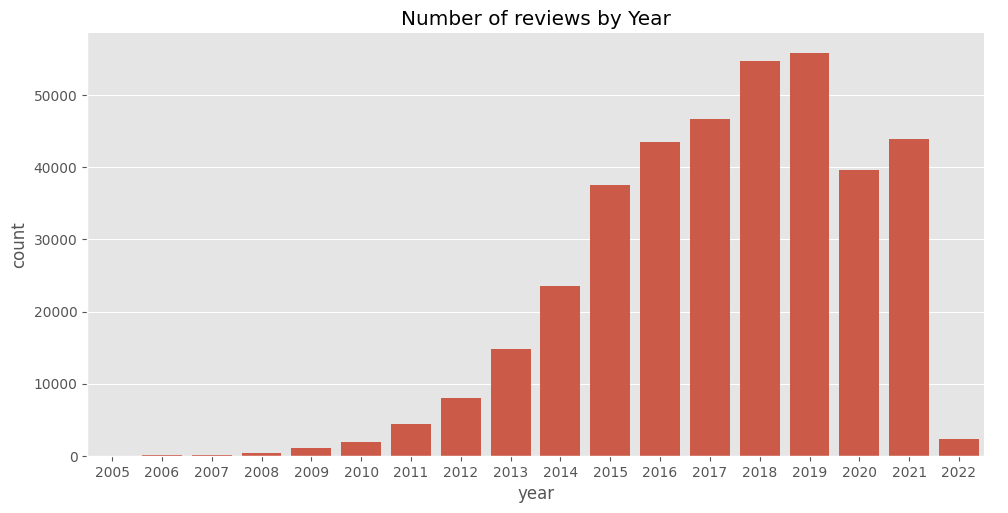

In [12]:
g = sns.catplot(data=date_df, x='year', kind='count', aspect=2)
ax = plt.gca()
ax.set_title('Number of reviews by Year')

Vemos que el número de revisiones ha aumentado exponencialmente a lo largo de los años. Esto también podría ser una prueba de la popularidad de Yelp a lo largo de los años.

Text(0.5, 1.0, 'Ratings by Month')

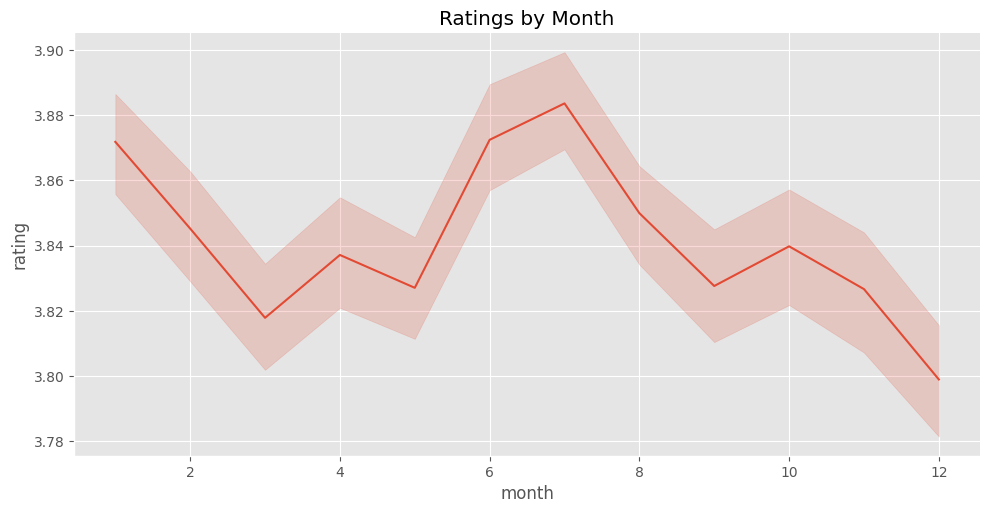

In [13]:
g = sns.relplot(data=date_df, x='month', y='rating', aspect=2, kind='line')
ax = plt.gca()
ax.set_title('Ratings by Month')

Vemos que la calificación promedio después del facetado mensual es mínima para el mes 12 ~ diciembre. Pero si miramos la escala y, el cambio no es tan significativo como para trazar una tendencia.

Text(0.5, 1.0, 'Ratings by Day')

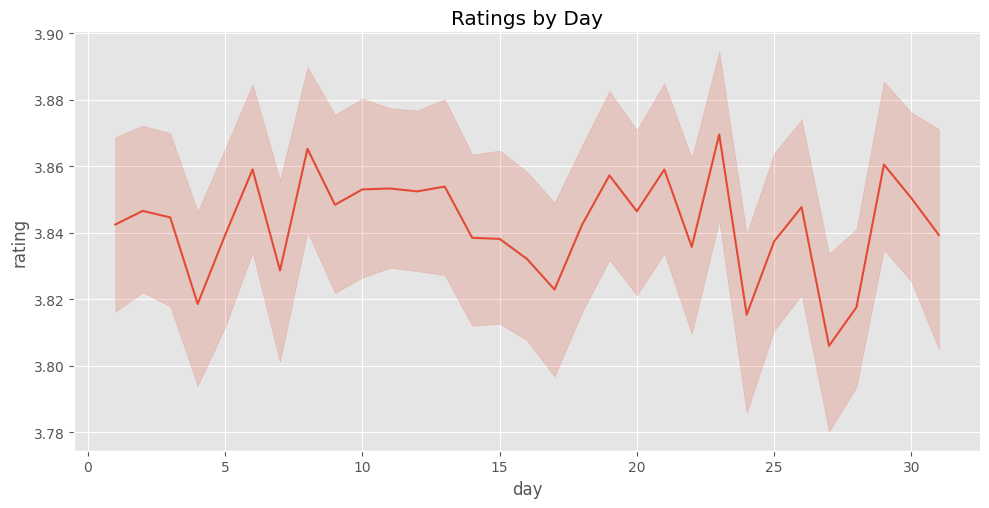

In [14]:
g = sns.relplot(data=date_df, x='day', y='rating', aspect=2, kind='line')
ax = plt.gca()
ax.set_title('Ratings by Day')

Vemos que la calificación promedio después del recolectado en un día es constante del quinto al  día 20. Pero si miramos la escala y, el cambio no es tan significativo como para trazar una tendencia.

Text(0.5, 1.0, 'Review Time')

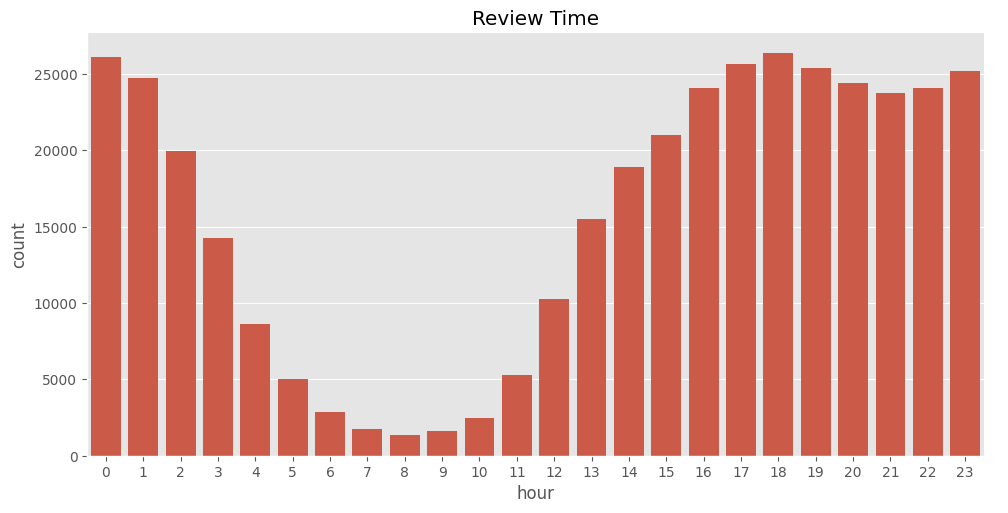

In [15]:
sns.catplot(data=date_df, x='hour', aspect=2, kind='count')
ax = plt.gca()
ax.set_title('Review Time')

Esto es interesante ya que vemos que se dio una cantidad mínima de revisiones durante la mañana y el recuento sigue aumentando a lo largo del día, lo que parece intuitivo. Pero el número máximo de reseñas se dio a las 0 a.m., lo cual es contrario a la intuición. ¿Por qué hay más personas revisando esto tarde? ¿Es posible que estos sean bares donde la gente se queda por mucho tiempo pero por qué a la gente nochera les importaría reseñar? ¿O la gente está revisando después de la cena durante el viaje a casa? Tendríamos que examinar más pruebas para sacar conclusiones.

In [16]:
#liberar memoria
del date_df

In [17]:
#Mirando columnas y haciendo un DataFrame a partir de la tabla de usuarios
cols = list(zip(*make_query("PRAGMA table_info(users)")))[1]
users_df = make_frame(query='SELECT * FROM users;', legend=cols)
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987897 entries, 0 to 1987896
Data columns (total 22 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             int64  
 1   name                object 
 2   review_count        int64  
 3   yelping_since       object 
 4   useful              int64  
 5   funny               int64  
 6   cool                int64  
 7   elite               object 
 8   friends             object 
 9   fans                int64  
 10  average_stars       float64
 11  compliment_hot      int64  
 12  compliment_more     int64  
 13  compliment_profile  int64  
 14  compliment_cute     int64  
 15  compliment_list     int64  
 16  compliment_note     int64  
 17  compliment_plain    int64  
 18  compliment_cool     int64  
 19  compliment_funny    int64  
 20  compliment_writer   int64  
 21  compliment_photos   int64  
dtypes: float64(1), int64(17), object(4)
memory usage: 333.7+ MB


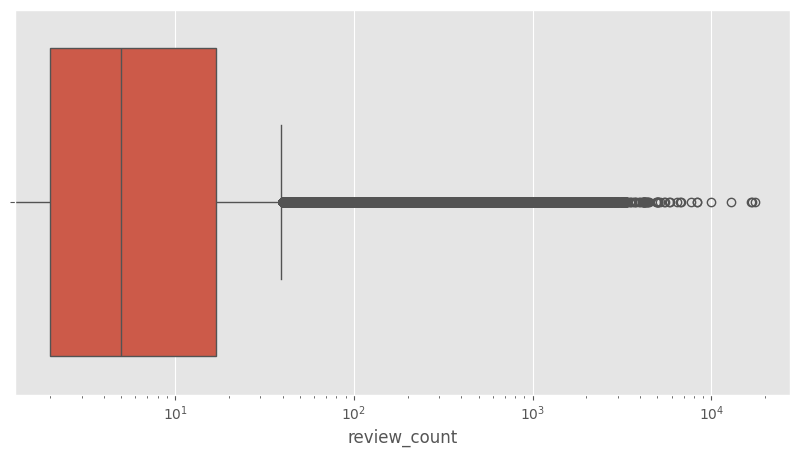

In [18]:
plt.figure(figsize=(10,5))
ax = plt.gca()
sns.boxplot(data=users_df, x='review_count', ax=ax)
plt.xscale('log')

El diagrama de caja del recuento de reseñas revela muchos valores atípicos. Hay algunos usuarios que han escrito más de 10.000 reseñas.

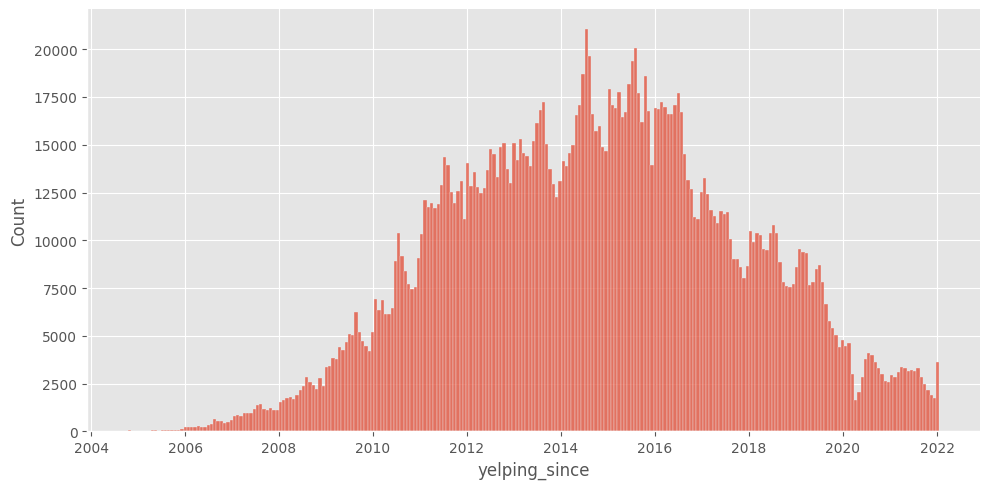

In [19]:
#Type Cast  al formato de fecha y hora
users_df.yelping_since = pd.to_datetime(users_df.yelping_since)
sns.displot(data=users_df, x='yelping_since', aspect=2)

La mayoría de la gente está utilizando yel desde mediados de la década de 2010.

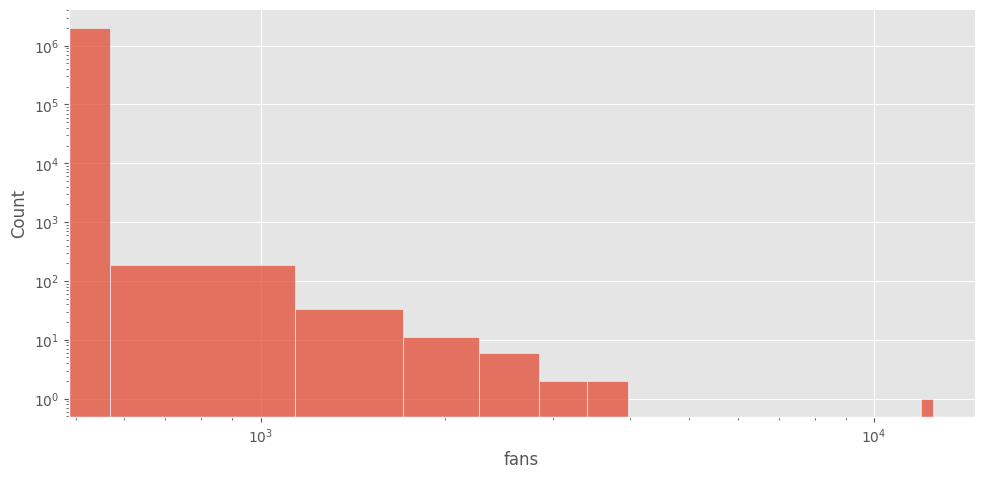

In [20]:
sns.displot(data=users_df, x='fans', aspect=2)
plt.xscale('log')
plt.yscale('log')

Algunos usuarios  críticos son muy populares en Yelp. La mayoría de la gente tiene pocos o ningún fan.

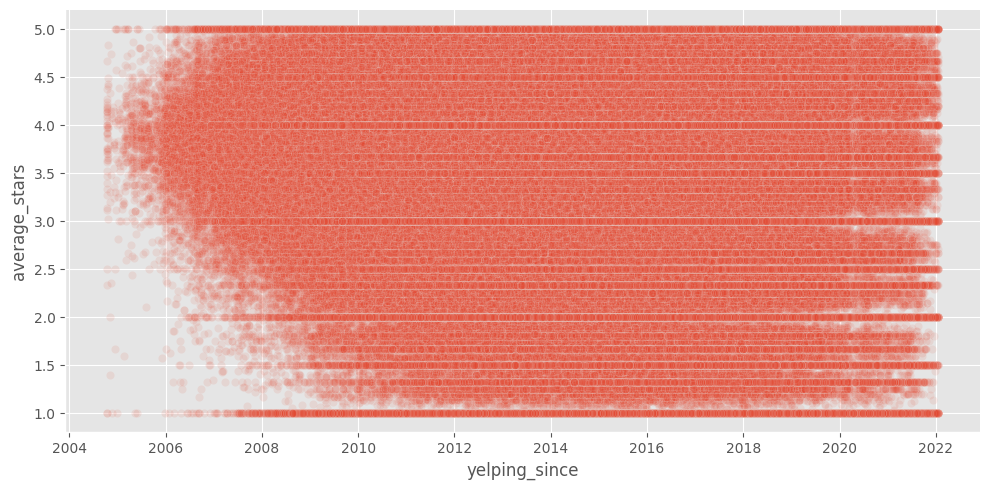

In [21]:
sns.relplot(data=users_df, x='yelping_since', y='average_stars',alpha=.1, aspect=2)

Vemos que los críticos que han estado usando yelp durante mucho tiempo tienen una calificación promedio más alta.

In [22]:
#Liberar memoria
del users_df

#Businesses tabla

In [23]:
# Mirando las columnas de la tabla de negocios y su tipos
make_query("PRAGMA table_info(businesses)")

[(0, 'business_id', 'INTEGER', 1, None, 1),
 (1, 'name', 'VARCHAR', 0, None, 0),
 (2, 'address', 'VARCHAR', 0, None, 0),
 (3, 'city', 'VARCHAR', 0, None, 0),
 (4, 'state', 'VARCHAR', 0, None, 0),
 (5, 'postal_code', 'VARCHAR', 0, None, 0),
 (6, 'latitude', 'FLOAT', 0, None, 0),
 (7, 'longitude', 'FLOAT', 0, None, 0),
 (8, 'stars', 'FLOAT', 0, None, 0),
 (9, 'review_count', 'INTEGER', 0, None, 0),
 (10, 'is_open', 'BOOLEAN', 0, None, 0),
 (11, 'categories', 'VARCHAR', 0, None, 0),
 (12, 'Alcohol', 'BOOLEAN', 0, None, 0),
 (13, 'OutdoorSeating', 'BOOLEAN', 0, None, 0),
 (14, 'RestaurantsReservations', 'BOOLEAN', 0, None, 0),
 (15, 'Ambience', 'BOOLEAN', 0, None, 0),
 (16, 'GoodForMeal', 'BOOLEAN', 0, None, 0),
 (17, 'BusinessParking', 'BOOLEAN', 0, None, 0),
 (18, 'ByAppointmentOnly', 'BOOLEAN', 0, None, 0),
 (19, 'RestaurantsGoodForGroups', 'BOOLEAN', 0, None, 0),
 (20, 'WiFi', 'BOOLEAN', 0, None, 0),
 (21, 'RestaurantsPriceRange2', 'BOOLEAN', 0, None, 0),
 (22, 'RestaurantsDelivery', '

In [24]:
#Obtener marco de datos de la tabla
business_df_cols = list(zip(*make_query("PRAGMA table_info(businesses)")))[1]
business_df = make_frame(query='SELECT * FROM businesses', legend=business_df_cols)
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,AgesAllowed,Open24Hours,DietaryRestrictions,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,...,0,0,0,11:0-14:0,11:0-14:0,11:0-14:0,11:0-14:0,11:0-14:0,5:0-10:0,15:0-18:0
1,1,Adams Dental,15 N Missouri Ave,Clearwater,FL,33755,27.966235,-82.787412,5.0,10,...,0,0,0,7:30-15:30,7:30-15:30,7:30-15:30,7:30-15:30,None,None,None
2,2,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,...,0,0,0,10:0-18:0,10:0-20:0,10:0-20:0,10:0-20:0,10:0-20:0,10:0-20:0,None
3,3,Charlie's Market,2815 E Sligh Ave,Tampa,FL,33610,28.010360,-82.430042,3.0,9,...,0,0,0,None,None,None,None,None,None,None
4,4,Publix Super Market,12101 Little Rd,Hudson,FL,34667,28.332601,-82.668107,3.5,7,...,0,0,0,None,None,None,None,None,None,None


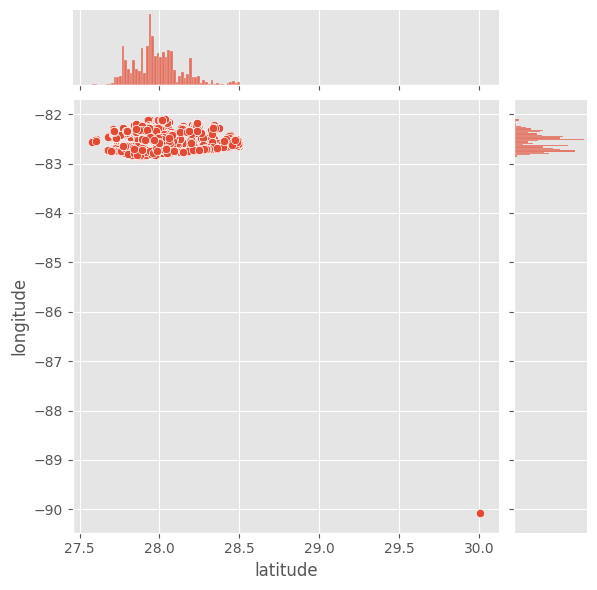

In [25]:
sns.jointplot(data=business_df, x='latitude', y='longitude')

Vemos que las ubicaciones de las empresas se concentran en un solo grupo. Este grupo debe ser una gran ciudad. Tracémoslos en un mapa.

In [27]:
def plot(feature):
    plt.figure(figsize=(8, 8))
    sns.relplot(data=business_df, y='stars', x='review_count', col=feature, alpha=.4)

bool_features = []
for tup in make_query("PRAGMA table_info(businesses)"):
    if tup[2]=='BOOLEAN':
        bool_features.append(tup[1])

for feature in bool_features:
    plot(feature)

Output hidden; open in https://colab.research.google.com to view.

Las empresas con vestimenta tienen calificaciones más altas y un mayor número de reseñas, por lo que son más populares que aquellas sin vestimenta.

Los negocios con TakeOut, AcceptCreditCard, GoodForKids, Reservation, GoodForGroups, BusinessParking, HasTV, Alcohol, BikeParking, Delivery, OutdoorSeating, WiFi, Ambience, DogsAllowed, GoodForDancing, CoatCheck y CounterService muestran una tendencia similar.

Los negocios con ruido también tienen calificaciones promedio más altas, esto podría deberse a que están ubicados en ubicaciones privilegiadas.

Los negocios ByAppointmentOnly muestran una tendencia más o menos similar a aquellos con Not ByAppointmentOnly.

Los restaurantes con asientos al aire libre tienen mejores calificaciones y un mayor número de reseñas que aquellos sin asientos al aire libre. De ahí que los restaurantes con asientos al aire libre sean más populares.

Los lugares accesibles en silla de ruedas no obtienen mejores resultados que los que no lo son.

Los negocios con WiFi también son más populares que los que no la tienen.
Algunos restaurantes sin TableService tienen un mayor número de reseñas que aquellos con.

Los sitios donde se admiten perros también parecen más populares,
Aire acondicionado también, el ambiente juega un papel importante en la calificación y el recuento de reseñas. Los que tienen ambiente son más populares.

Las parcelas para negocios con HappyHour, DriveThrough, Music, BestNights o AcceptsBitcoin no difieren significativamente de los que no lo tienen.
Los negocios sin restricciones dietéticas tienen mejores calificaciones que aquellos que sí las tienen.

Los negocios con Open24Hours=0 están subrepresentados

Text(0, 0.5, 'Count')

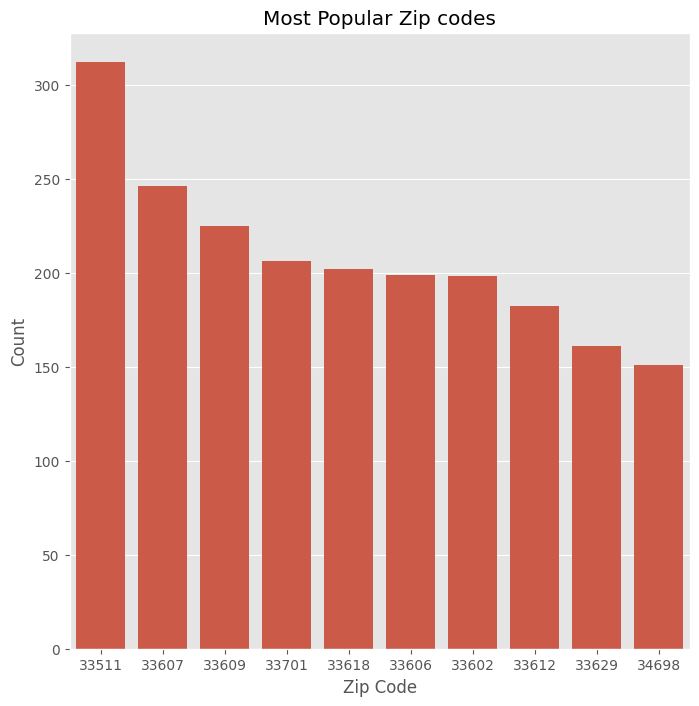

In [28]:
plt.figure(figsize=(8,8))
top_10_zip = business_df.postal_code.value_counts()[:10]
sns.barplot(x=top_10_zip.index, y=top_10_zip.values)
ax = plt.gca()
ax.set_title('Most Popular Zip codes')
ax.set_xlabel('Zip Code')
ax.set_ylabel('Count')

Nuestros datos tienen la mayor cantidad de empresas del código postal 33511 (Brandon). Esto se puede verificar en el mapa.

<ipython-input-29-7e9553f1823c>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 8)


[Text(0.5, 0, 'Business'), Text(0, 0.5, 'Review Count')]

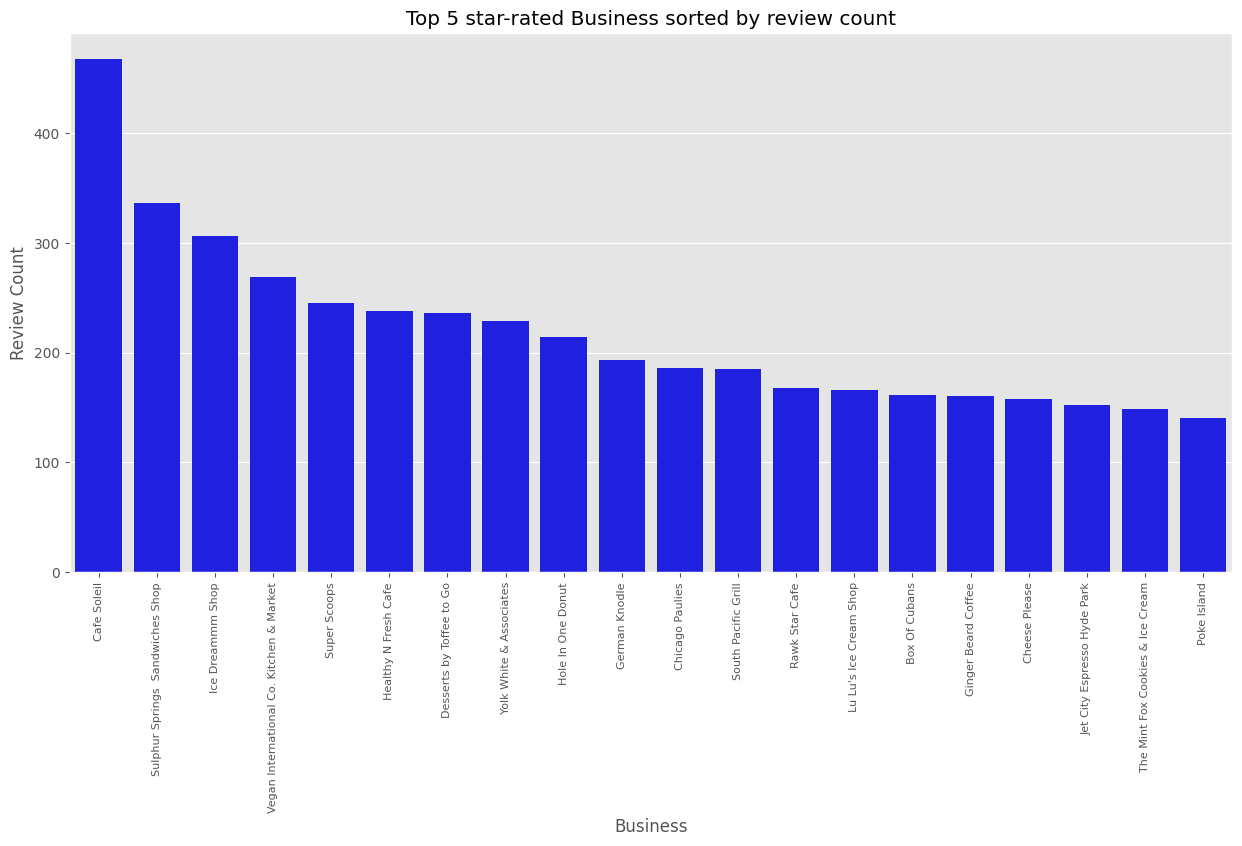

In [29]:
toprating_df = business_df[business_df["stars"]==5]
toprating_df = toprating_df.sort_values('review_count', ascending=False).head(20)

plt.figure(figsize=(15,7))
p = sns.barplot(x='name', y="review_count", data=toprating_df,color="b")
p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 8)
p.set_title("Top 5 star-rated Business sorted by review count")
p.set(xlabel="Business", ylabel="Review Count")

Empresas saludables con calificaciones = 5 y el mayor número de reseñas

<ipython-input-30-ea7e32d72cc0>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 8)


[Text(0.5, 0, 'business'), Text(0, 0.5, 'Rating')]

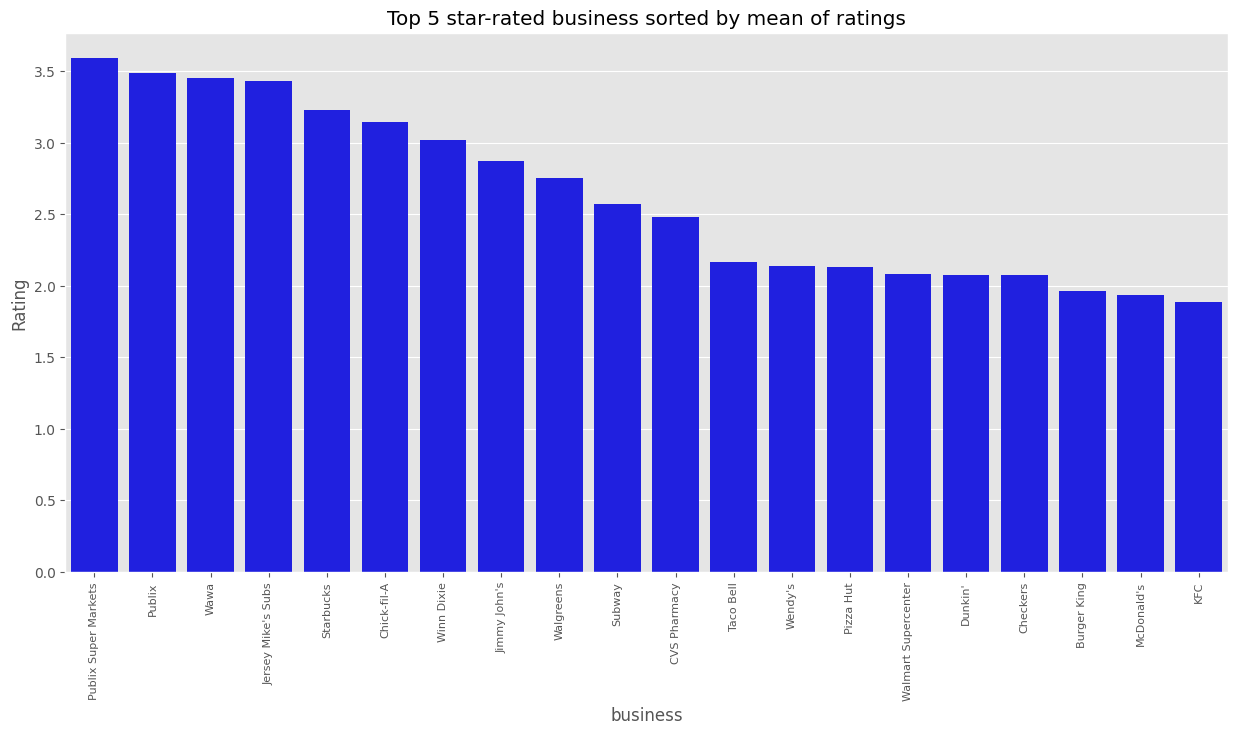

In [30]:
df_restaurants = business_df.name.value_counts().index[:20].tolist()
df_top = business_df.loc[business_df['name'].isin(df_restaurants)]
mean_df = df_top.groupby('name')['stars'].mean()
meanrating_df = mean_df.reset_index()
topmean_rating_df = meanrating_df.sort_values('stars', ascending=False).head(20)

plt.figure(figsize=(15,7))
p = sns.barplot(x='name', y="stars",data=topmean_rating_df, color="b")
p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 8)
p.set_title("Top 5 star-rated business sorted by mean of ratings")
p.set(xlabel="business", ylabel="Rating")

Empresas con puntuaciones medias más altas de calificaciones.

<ipython-input-31-fac1110e5d0f>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 80)` for the same effect.

  sns.lineplot(x=business_df["stars"],y=business_df["review_count"],hue=business_df["DriveThru"],ci=80)


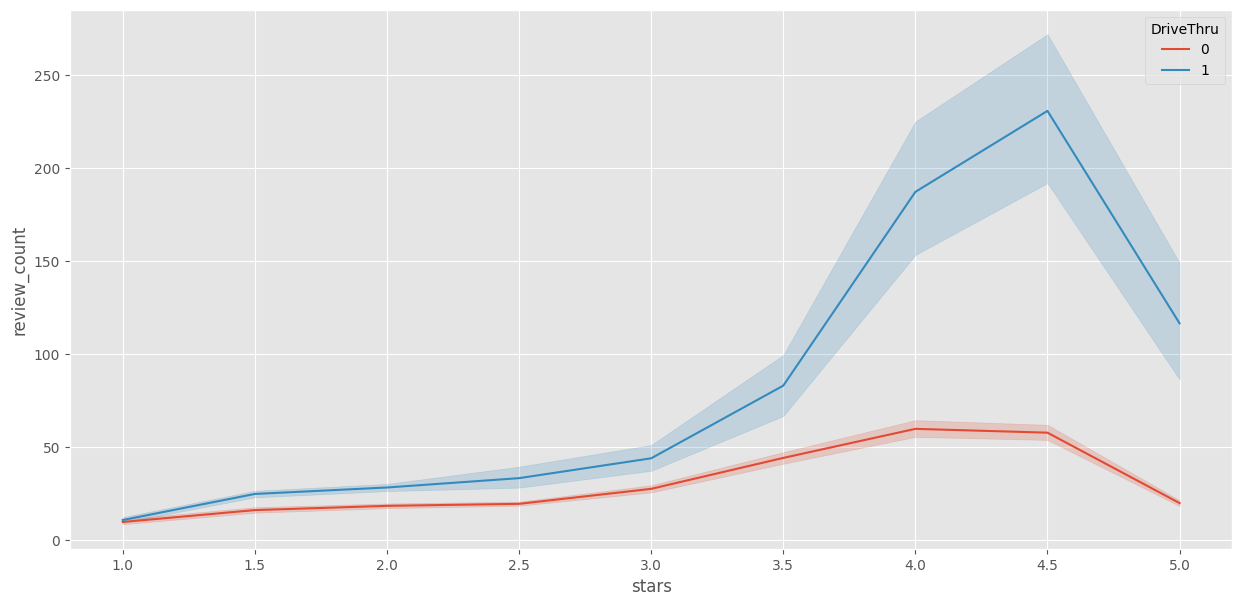

In [31]:
plt.figure(figsize=(15,7))
sns.lineplot(x=business_df["stars"],y=business_df["review_count"],hue=business_df["DriveThru"],ci=80)
plt.legend(bbox_to_anchor=(1.00, 1), title ="DriveThru")
plt.show()

Las empresas con 'Drive Through' tienen calificaciones más altas y un mayor número de reseñas. De ahí que sean más populares.

<ipython-input-32-3071f7a38a8e>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 80)` for the same effect.

  sns.lineplot(x=business_df["stars"],y=business_df["review_count"],hue=business_df["GoodForDancing"],ci=80)


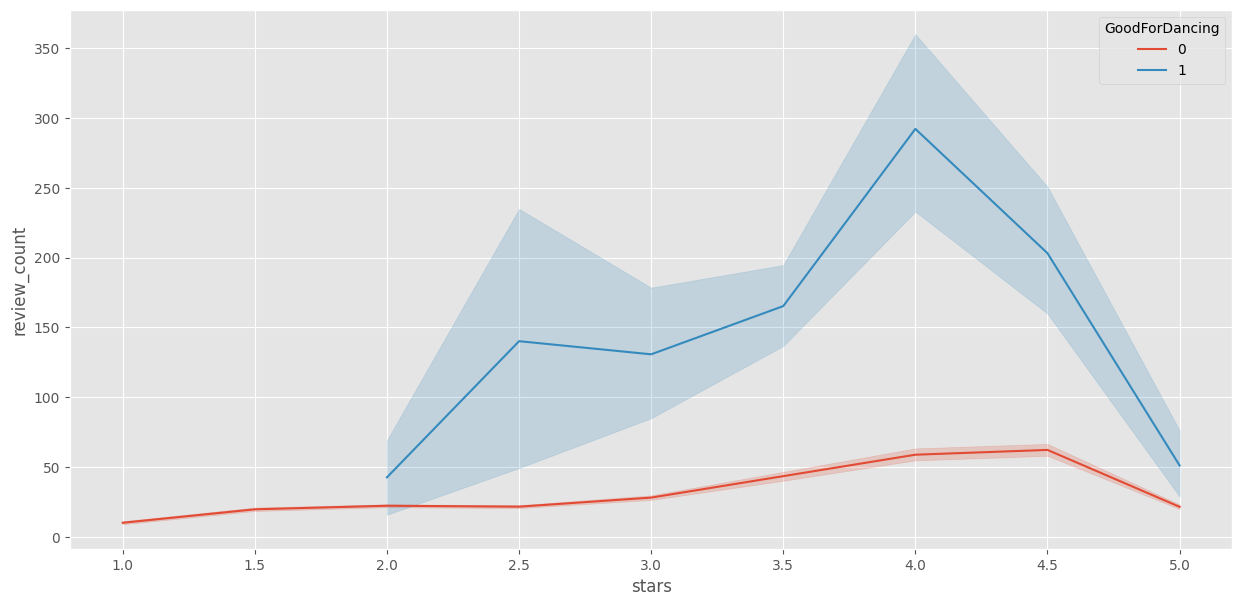

In [32]:
plt.figure(figsize=(15,7))
sns.lineplot(x=business_df["stars"],y=business_df["review_count"],hue=business_df["GoodForDancing"],ci=80)
plt.legend(bbox_to_anchor=(1.00, 1), title ="GoodForDancing")
plt.show()

La empresa con GoodForDancing también parece más popular.

<ipython-input-33-f0f8013fb516>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(business_df.corr(),annot=False)


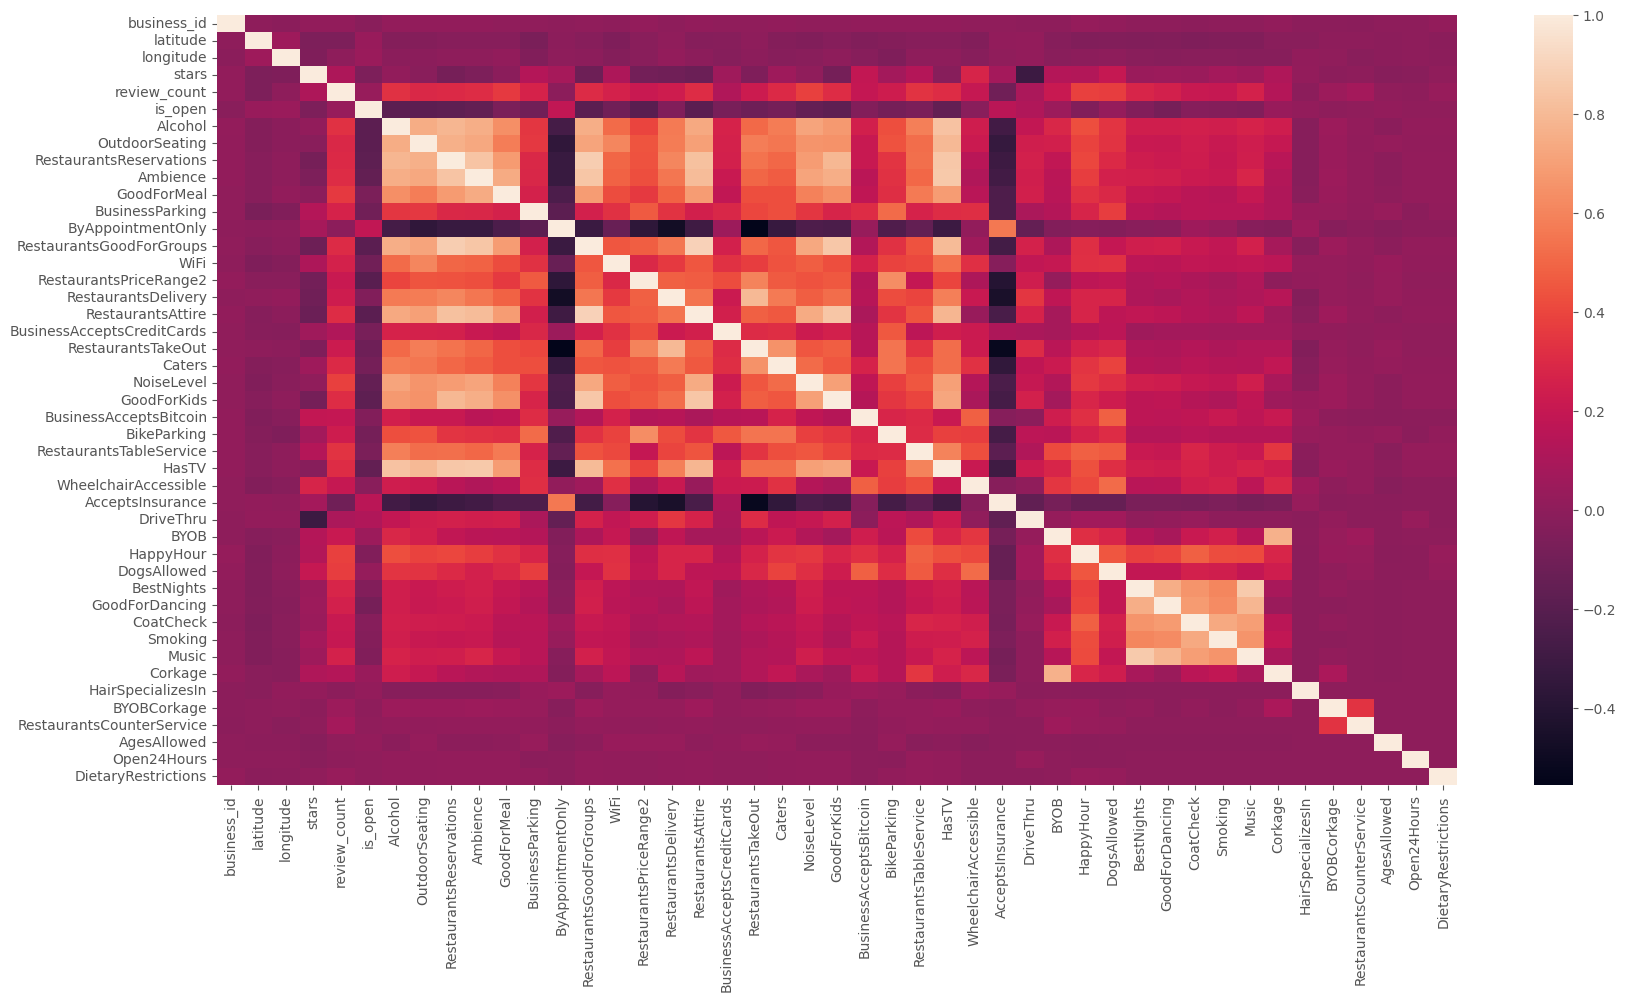

In [33]:
plt.figure(figsize=(20,10))
sns.heatmap(business_df.corr(),annot=False)
plt.show()

Vemos algunas correlaciones aproximadamente en el centro del mapa de calor. Podrían deberse a funciones redundantes, como que un lugar con aparcamiento probablemente tenga 'BikeParking', o porque los negocios de alta gama tienen la mayoría de las funciones enumeradas.

#Conclusion
Estudiamos varias tramas.
Los restaurantes con 'TakeOut', 'AcceptCreditCard', 'GoodForKids', 'Reserva', 'GoodForGroups', 'BusinessParking', 'HasTV', 'Alcohol', 'BikeParking', 'Delivery', 'OutdoorSeating', 'WiFi', 'Ambience', 'DogsAllowed', 'GoodForDancing', 'CoatCheck', 'CounterService', 'Attire' son más populares en general.
